In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  Apple Localization

## Installing Packages

In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

## Libraries

In [2]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Exploring Data

In [3]:
!cat ../input/apple-quality-dataset/Apple_Detection.v1i.yolov8/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['apple']

roboflow:
  workspace: lakshantha-dissanayake
  project: apple-detection-5z37o
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/lakshantha-dissanayake/apple-detection-5z37o/dataset/1

In [4]:
# Load the YAML file
with open('../input/apple-quality-dataset/Apple_Detection.v1i.yolov8/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data. You must use absolute path, relative path won't work
data_yaml['train'] = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/train/images'
data_yaml['val'] = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [5]:
data_dir = Path("../input/apple-quality-dataset/Apple_Detection.v1i.yolov8")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [6]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(192, 192)}


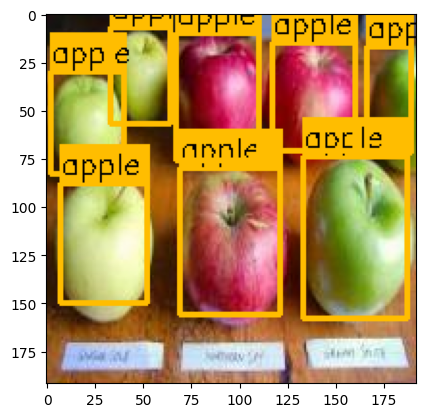

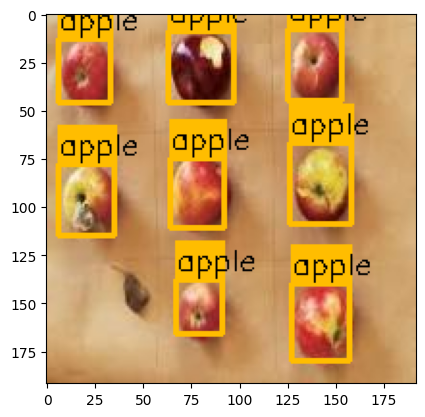

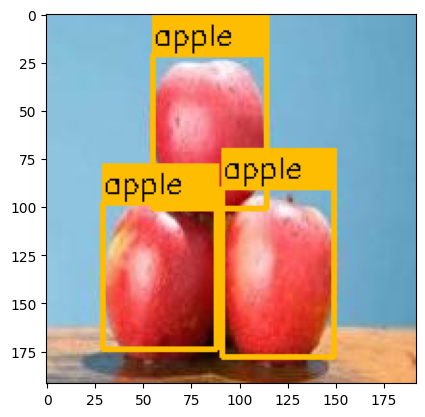

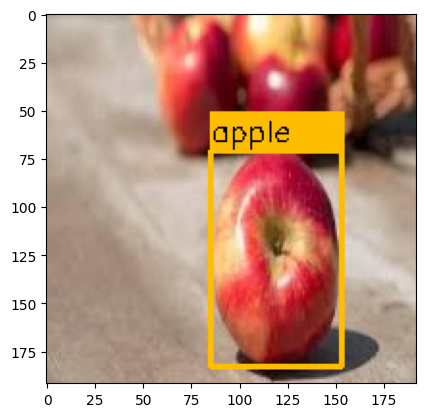

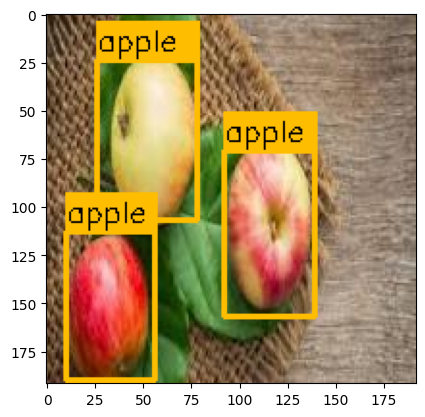

In [7]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(0,189,255)] 

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [1]:
# Pip install method (recommended)
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.6/8062.4 GB disk)


In [2]:
# Git clone method (for development)
!git clone https://github.com/ultralytics/ultralytics
%pip install -qe ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 45724, done.
remote: Counting objects: 100% (675/675), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 45724 (delta 551), reused 301 (delta 282), pack-reused 45049 (from 4)
Receiving objects: 100% (45724/45724), 39.00 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (33871/33871), done.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os # operating system

In [4]:
mkdir /kaggle/working/ultralytics/mydata

In [5]:
mkdir /kaggle/working/ultralytics/mydata/images

In [6]:
mkdir /kaggle/working/ultralytics/mydata/labels

In [7]:
mkdir /kaggle/working/ultralytics/mydata/images/train

In [8]:
mkdir /kaggle/working/ultralytics/mydata/images/test

In [9]:
mkdir /kaggle/working/ultralytics/mydata/labels/train

In [10]:
mkdir /kaggle/working/ultralytics/mydata/labels/test

In [11]:
cd /kaggle/working/ultralytics/mydata

/kaggle/working/ultralytics/mydata


In [12]:
from distutils.dir_util import copy_tree

In [13]:
cd /kaggle

/kaggle


In [14]:
# Copy train images from kaggle input directory to kaggle output directory
fromDir = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/train/images'
toDirectory = '/kaggle/working/ultralytics/mydata/images/train'
copy_tree(fromDir, toDirectory)

['/kaggle/working/ultralytics/mydata/images/train/apple--13-_jpg.rf.a85399c077972fcb78f2a5e467f75a9b.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/damaged_apple--259-_jpg.rf.3339bdcced9b7eaaec10fa281707196f.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/damaged_apple--149-_jpg.rf.6d873add386f3afbaf892034c32ecc0e.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--164-_jpg.rf.4e9dda85d94953b4ed4d56a141ff5eec.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--255-_jpg.rf.56603935290606356ba3d743b2d231a4.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--130-_jpg.rf.347c424e3d19ca4fe8d26703f85191be.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--225-_jpg.rf.c3e611a216e7b57108917751fb61157d.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--163-_jpg.rf.a2d316fcbce511a1dc2f1ed0ae2e4182.jpg',
 '/kaggle/working/ultralytics/mydata/images/train/apple--259-_jpg.rf.86cf5a6be2dfeb74af303acd0ea78c87.jpg',
 '/kaggle/wor

In [15]:
# Copy test images from kaggle input directory to kaggle output directory
fromDir = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/valid/images'
toDirectory = '/kaggle/working/ultralytics/mydata/images/val'
copy_tree(fromDir, toDirectory)

['/kaggle/working/ultralytics/mydata/images/val/damaged_apple--302-_jpg.rf.2f8d6e735b87e70d1e4862c033005f01.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/damaged_apple--344-_jpg.rf.79a487de55befe015cfa8138f569d31b.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/apple--358-_jpg.rf.a54ae95d4fd5a49e27ce361be0d7fa62.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/damaged_apple--284-_jpg.rf.ec72a236fd3e24ff5ba85c605e0e6e82.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/apple--305-_jpg.rf.b4edf325ef2a382abd94ad4d4bdc5247.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/damaged_apple--275-_jpg.rf.9da46e109400a9db19aabc409a1bc76f.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/apple--306-_jpg.rf.1957ed71c6a5e703b9da3d1b4654e80b.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/damaged_apple--341-_jpg.rf.2c91234b279070eaf40eabdda1e2a2b2.jpg',
 '/kaggle/working/ultralytics/mydata/images/val/damaged_apple--296-_jpg.rf.84d9e7504c31887499c8ccaa54262ba7.jpg'

In [16]:
# Copy train labels from kaggle input directory to kaggle output directory
fromDir = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/train/labels'
toDirectory = '/kaggle/working/ultralytics/mydata/labels/train'
copy_tree(fromDir, toDirectory)

['/kaggle/working/ultralytics/mydata/labels/train/apple--247-_jpg.rf.c23cbb05f9ad08f80e4eb0a49547a800.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/apple--204-_jpg.rf.c07a2f9ff879df0b6465e5b3f8f33d4f.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/damaged_apple--26-_jpg.rf.6cb3dabdb5b5f0df1b7b291add891821.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/apple--103-_jpg.rf.d8166105293531a775c0af5c8e841ae0.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/damaged_apple--71-_jpg.rf.c50722a4d6d962e34281259e3dcf86c5.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/damaged_apple--132-_jpg.rf.08a6d2cf103c4c75c863930181851cbc.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/damaged_apple--68-_jpg.rf.2e803352bfd0c24a0de1bf4aa5b736b8.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/apple--168-_jpg.rf.326f362a2901ef81ed4a4d6a59a93b5a.txt',
 '/kaggle/working/ultralytics/mydata/labels/train/apple--207-_jpg.rf.4f69deba21e580875e29a85784d01a65.txt',

In [17]:
# Copy valid labels from kaggle input directory to kaggle output directory
fromDir = '/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/valid/labels'
toDirectory = '/kaggle/working/ultralytics/mydata/labels/val'
copy_tree(fromDir, toDirectory)

['/kaggle/working/ultralytics/mydata/labels/val/apple--365-_jpg.rf.2ab06cb23d922ae1a7b42342ab732ba9.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--316-_jpg.rf.c80b30b686ffaddfbe0f93679ff222e7.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/damaged_apple--331-_jpg.rf.99a603f355c0f0189ffe7ff70b1b3148.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--344-_jpg.rf.a3180bdfb00aee3777e440651e7a4fa1.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--307-_jpg.rf.4c2b99de1d5111400c0351d2713d0319.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--363-_jpg.rf.6046be0878512abd0436bce59c2a5605.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--345-_jpg.rf.627f7df039b63293a8823de27f609bf6.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/apple--332-_jpg.rf.09f22428636bada6fa5dcc62598ba902.txt',
 '/kaggle/working/ultralytics/mydata/labels/val/damaged_apple--309-_jpg.rf.7d2418846138fe929dabd181109d4e9a.txt',
 '/kaggle/working/ultralytics/

## Model Development

In [18]:
# Train YOLOv8n on COCO128 for 300 epochs
!yolo task=detect mode=train model=yolov8n.pt data=/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/data.yaml epochs=300 imgsz=640 batch=32 cache=disk

100%|██████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 18.9MB/s]
Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/data.yaml, epochs=300, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=disk, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

## Model Evaluation

In [21]:
!yolo task=detect mode=val model=/kaggle/runs/detect/train/weights/best.pt data=/kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/data.yaml

Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/val
val: WARNING ⚠️ Cache directory /kaggle/input/apple-quality-dataset/Apple_Detection.v1i.yolov8/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        146        572      0.861      0.853       0.91      0.631
Speed: 2.2ms preprocess, 14.5ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val



Detailed Metrics:


,Value
Metric,
Precision,0.861
Recall,0.853
mAP50,0.910
mAP50-95,0.631
F1,0.857


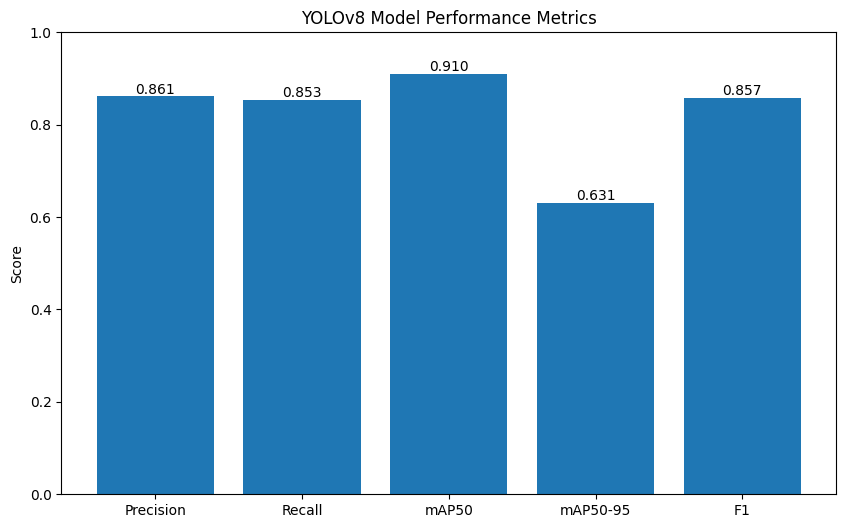

In [22]:
def display_metrics():
    # Metrics from your validation results
    metrics = {
        'Precision': 0.861,  # Box(P) from your output
        'Recall': 0.853,     # R from your output
        'mAP50': 0.91,       # mAP50 from your output
        'mAP50-95': 0.631    # from your output
    }
    
    # Calculate F1 Score
    metrics['F1'] = 2 * (metrics['Precision'] * metrics['Recall']) / (metrics['Precision'] + metrics['Recall'])
    
    # Create a DataFrame for better visualization
    df = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Value': list(metrics.values())
    })
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Metric'], df['Value'])
    plt.title('YOLOv8 Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    # Display numeric values in a table
    print("\nDetailed Metrics:")
    display(df.set_index('Metric').round(3))
    
    plt.show()

# Run the visualization
display_metrics()